Feature Selection Comparison:

Firstly loaded the data and extracted target and features.

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
data = load_breast_cancer()
X = data.data          # features
y = data.target        # labels
feature_names = data.feature_names

print("Data shape:", X.shape)
print("Target shape:", y.shape)


Data shape: (569, 30)
Target shape: (569,)


Split the data into train and test, and scaled them.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 398
Test samples: 171


Fit a SVM model and checked how well it performs using all features. We can see that the test accuracy is quite high when using all features.

Training accuracy: 0.9874
Test accuracy: 0.9766


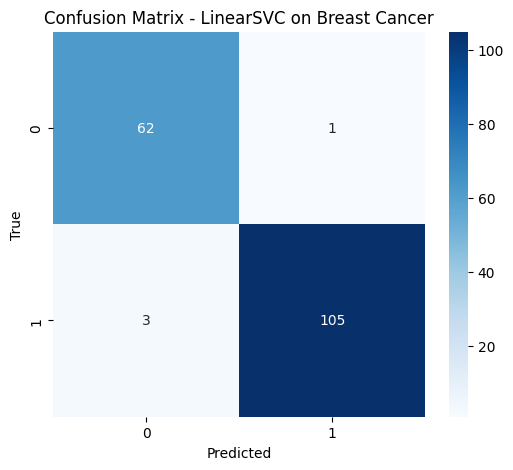

In [35]:
# LinearSVC can need more iterations for convergence
model = LinearSVC(random_state=4, max_iter=10000)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LinearSVC on Breast Cancer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Use greedy forward selection to select features based on cross-validated accuracy. 10-fold cross-validation is used to evaluate feature subsets. We can see that there are some small drops
in accuracy even tho we increase the number of variables, that could be avoided using a stopping point but for this task we want to find out how each step changes the accuracy score so we keep it as is, but overall the accuracy remains quite high. Especially after 5 features, the accuracy stabilizes around .97.

In [36]:
n_features = X.shape[1]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

selected_features_forward = []
remaining_features = list(range(n_features))
forward_scores = []
print("\n--- Forward Greedy Feature Selection ---")
for _ in range(n_features):
    best_score = 0
    best_feature = None
    for f in remaining_features:
        features_to_try = selected_features_forward + [f]
        model = LinearSVC(max_iter=10000, random_state=4)
        scores = cross_val_score(model, X_train[:, features_to_try], y_train, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_feature = f
    selected_features_forward.append(best_feature)
    remaining_features.remove(best_feature)
    forward_scores.append(best_score)
    print(f"Step {_+1}: add feature {feature_names[best_feature]}, CV accuracy = {best_score:.4f}")



--- Forward Greedy Feature Selection ---
Step 1: add feature mean concave points, CV accuracy = 0.9121
Step 2: add feature mean texture, CV accuracy = 0.9348
Step 3: add feature worst perimeter, CV accuracy = 0.9499
Step 4: add feature worst texture, CV accuracy = 0.9674
Step 5: add feature texture error, CV accuracy = 0.9699
Step 6: add feature area error, CV accuracy = 0.9700
Step 7: add feature mean compactness, CV accuracy = 0.9725
Step 8: add feature mean radius, CV accuracy = 0.9750
Step 9: add feature mean perimeter, CV accuracy = 0.9750
Step 10: add feature mean area, CV accuracy = 0.9750
Step 11: add feature mean smoothness, CV accuracy = 0.9750
Step 12: add feature smoothness error, CV accuracy = 0.9750
Step 13: add feature worst area, CV accuracy = 0.9750
Step 14: add feature concave points error, CV accuracy = 0.9750
Step 15: add feature perimeter error, CV accuracy = 0.9750
Step 16: add feature fractal dimension error, CV accuracy = 0.9750
Step 17: add feature worst radiu

Greedy backward feature selection is utilised next, we can see that it starts to drop drastically on the last 5 steps, small flactuations are again expectedly observed. Last 6 features are stored for comparison for the last task.

In [37]:
selected_features_backward = list(range(n_features))
backward_scores = []
removed_features = []
for _ in range(n_features-1):
    best_score = 0
    worst_feature = None
    for f in selected_features_backward:
        features_to_try = [feat for feat in selected_features_backward if feat != f]
        model = LinearSVC(max_iter=10000, random_state=4)
        scores = cross_val_score(model, X_train[:, features_to_try], y_train, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            worst_feature = f
    selected_features_backward.remove(worst_feature)
    removed_features.append(worst_feature)
    backward_scores.append(best_score)
    print(f"Step {_+1}: remove feature {feature_names[worst_feature]}, CV accuracy = {best_score:.4f}")
top6_backward = [f for f in range(n_features) if f not in removed_features[:n_features-6]]
print("Top 6 features (Backward Selection):", feature_names[top6_backward])


Step 1: remove feature smoothness error, CV accuracy = 0.9699
Step 2: remove feature radius error, CV accuracy = 0.9749
Step 3: remove feature mean radius, CV accuracy = 0.9749
Step 4: remove feature mean texture, CV accuracy = 0.9749
Step 5: remove feature perimeter error, CV accuracy = 0.9774
Step 6: remove feature fractal dimension error, CV accuracy = 0.9799
Step 7: remove feature mean perimeter, CV accuracy = 0.9799
Step 8: remove feature mean fractal dimension, CV accuracy = 0.9799
Step 9: remove feature mean smoothness, CV accuracy = 0.9799
Step 10: remove feature mean concavity, CV accuracy = 0.9799
Step 11: remove feature worst perimeter, CV accuracy = 0.9799
Step 12: remove feature compactness error, CV accuracy = 0.9799
Step 13: remove feature mean compactness, CV accuracy = 0.9825
Step 14: remove feature concave points error, CV accuracy = 0.9800
Step 15: remove feature worst concave points, CV accuracy = 0.9825
Step 16: remove feature mean area, CV accuracy = 0.9825
Step 1

Although the best six features selected by the two methods only overlap in two variables, this discrepancy is likely due to backward selection accounting for dependencies among features, whereas the forward selection evaluates features more independently.

In [38]:
top6_forward = selected_features_forward[:6]


print("\nTop 6 features (Forward Selection):", feature_names[top6_forward])
print("Top 6 features (Backward Selection):", feature_names[top6_backward])



Top 6 features (Forward Selection): ['mean concave points' 'mean texture' 'worst perimeter' 'worst texture'
 'texture error' 'area error']
Top 6 features (Backward Selection): ['mean concave points' 'worst texture' 'worst area' 'worst smoothness'
 'worst compactness' 'worst symmetry']


We plot the cross-validation accuracy at each step for both methods. At this point we are still using the training data only, with 10fold CV. We can see the small flactuations on both and we can observe that backward selection performed a bit better.

0.97 0.9799358974358974


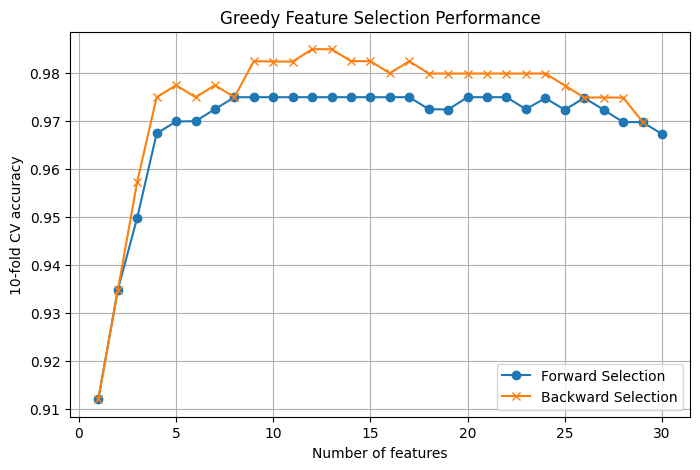

In [39]:
plt.figure(figsize=(8,5))
print(forward_scores[5], backward_scores[5])
plt.plot(range(1, n_features+1), forward_scores, marker='o', label='Forward Selection')
plt.plot(range(n_features-1, 0, -1), backward_scores, marker='x', label='Backward Selection')
plt.xlabel('Number of features')
plt.ylabel('10-fold CV accuracy')
plt.title('Greedy Feature Selection Performance')
plt.legend()
plt.grid(True)
plt.show()


Now, lastly, we compare the actual test error on both methods, and print the accuracy at 6 features. We can again observe flactuations, and we can see that backward selection performed a bit better on the smaller feature sets, for the high number of features fluctuations are likely caused by random error so they can be ignored for comparison, changing the seed on the first chunk will show that they differ slightly. The backward selection gave .97 accuracy while forward selection gave closer to .95 for this specific seed. As expected, backward selection performed better, this 2% matters considering we were able to drop the variables from 30 to 6 while only losing 1.6% on the backward elimination process.

Forward test accuracy with 6 features: 0.9532163742690059
Backward test accuracy with 6 features: 0.9707602339181286


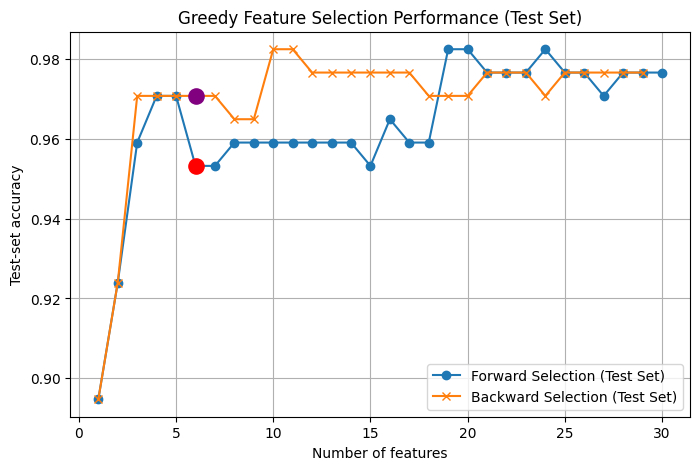

In [ ]:
# Forward test scores
forward_test_scores = []

for k in range(1, n_features+1):
    subset = selected_features_forward[:k]
    model = LinearSVC(max_iter=10000, random_state=42)
    model.fit(X_train[:, subset], y_train)
    acc = model.score(X_test[:, subset], y_test)
    forward_test_scores.append(acc)

# Backward test scores 
backward_test_scores = []

current_subset = list(range(n_features))

for removed in removed_features:
    current_subset = [f for f in current_subset if f != removed]
    model = LinearSVC(max_iter=10000, random_state=42)
    model.fit(X_train[:, current_subset], y_train)
    acc = model.score(X_test[:, current_subset], y_test)
    backward_test_scores.append(acc)

# Index for 6-feature backward result
idx_backward_6 = (n_features - 6) - 1

print("Forward test accuracy with 6 features:", forward_test_scores[5])
print("Backward test accuracy with 6 features:", backward_test_scores[idx_backward_6])

# Plot
plt.figure(figsize=(8,5))

# Forward curve
plt.plot(range(1, n_features+1),
         forward_test_scores,
         marker='o', label='Forward Selection (Test Set)')

# Backward curve
backward_x = list(range(n_features-1, 0, -1))
plt.plot(backward_x,
         backward_test_scores,
         marker='x', label='Backward Selection (Test Set)')

# Mark forward 6-feature point
plt.scatter(6, forward_test_scores[5], s=120, color='red', zorder=5)

# Mark backward 6-feature point
plt.scatter(6, backward_test_scores[idx_backward_6], s=120, color='purple', zorder=5)

plt.xlabel('Number of features')
plt.ylabel('Test-set accuracy')
plt.title('Greedy Feature Selection Performance (Test Set)')
plt.legend()
plt.grid(True)
plt.show()
